In [1]:
# placeholder jupyter notebook for the final project

In [2]:
import os

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt


# Assign spreadsheet filename to 'file'
Sales_file = 'Louisville Sales.xlsx'

# Load spreadsheet
salesxl = pd.ExcelFile(Sales_file)

# Print the sheet names
print(salesxl.sheet_names)

['sheet1']


In [3]:
# Load a sheet into a DataFrame by name: df1
df1 = salesxl.parse('sheet1')

# have to clean up the Age data because it is not always correct and it is being used in some decision making later

df1['Age'] = np.where(df1['Age'] > 3000, 0, df1['Age'])
df1['Age'] = np.where(df1['Age'] > 1000, 2020 - df1['Age'].astype(int), df1['Age'])
df1['Age'] = np.where(df1['Age'] > 400, 2020 - df1['Year Built'].astype(int), df1['Age'])
df1['Age'] = np.where(df1['Age'] > 400, 0, df1['Age'])



In [4]:
Rent_file = 'Rental data.xlsx'
rentxl = pd.ExcelFile(Rent_file)
print(rentxl.sheet_names)

['sheet1']


In [5]:
df2 = rentxl.parse('sheet1')

# needed to clean up the Rental Age data as well from wrong inputs

df2['Age'] = np.where(df2['Age'] > 3000, 0, df2['Age'])
df2['Age'] = np.where(df2['Age'] > 1800, 2020 - df2['Age'].astype(int), df2['Age'])
df2['Age'] = np.where(df2['Age'] > 400, 0, df2['Age'])


In [6]:
# need to drop rental data that is from before 2019 to make sure it is relevant
df2 = df2[(df2['Status Change Date'].dt.year >= 2019)]


In [7]:
# calculating subdivision level average price per sqft and average age and average size for both rental and sales

groupped_sales_df = df1.groupby('Subdivision/Condo')['Sold Price/SqFt', 'Age', 'SqFt -Total Finished'].mean().rename(columns={
    "Sold Price/SqFt": "Average_Sold_Price", 
    "Age": "Average_Sold_Age", 
    "SqFt -Total Finished": "Average_Sold_SqFt"
})

sales_count = df1.groupby('Subdivision/Condo')['Sold Price/SqFt', 'Age', 'SqFt -Total Finished'].size().reset_index(name='sales_count')
groupped_sales_df = pd.merge(groupped_sales_df, sales_count, on="Subdivision/Condo")
groupped_sales_df.head()

,Subdivision/Condo,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count
0,1400 Willow,335.096667,40.000000,2584.666667,3
1,2000 SPRING CONDOMIN,51.030000,64.000000,1113.000000,1
2,550 LOFTS,189.930000,97.000000,1211.000000,1
3,ABBEY WOODS,131.650000,24.500000,1871.500000,2
4,ABERDEEN,208.615714,79.214286,2469.500000,14


In [8]:
groupped_rental_df = df2.groupby('Subdivision/Condo')['List Price/SqFt', 'Age', 'SqFt -Total Finished'].mean().rename(columns={
    "List Price/SqFt": "Average_Rent_Price", 
    "Age": "Average_Rent_Age", 
    "SqFt -Total Finished": "Average_Rent_SqFt"
})


rent_count = df2.groupby('Subdivision/Condo')['List Price/SqFt', 'Age', 'SqFt -Total Finished'].size().reset_index(name='rent_count')

groupped_rental_df = pd.merge(groupped_rental_df, rent_count, on="Subdivision/Condo")

groupped_rental_df.head()

,Subdivision/Condo,Average_Rent_Price,Average_Rent_Age,Average_Rent_SqFt,rent_count
0,2000 SPRING CONDOMIN,1.030,102.0,1600.0,1
1,ABERDEEN,1.090,77.0,2641.0,1
2,ACADEMY RIDGE,0.925,17.5,2058.0,2
3,ACADEMY RIDGE AT LANDIS LAKE,1.000,17.0,2030.0,1
4,ADAMS RUN,1.000,19.5,1699.0,2


In [9]:
# Merge the 2 dataframes and only keep the subdivisions where there is both sales and rental data available 

subdivision_df = pd.merge(groupped_sales_df, groupped_rental_df, on="Subdivision/Condo", how='inner')
subdivision_df.head()

,Subdivision/Condo,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count,Average_Rent_Price,Average_Rent_Age,Average_Rent_SqFt,rent_count
0,2000 SPRING CONDOMIN,51.030000,64.000000,1113.000000,1,1.030,102.0,1600.0,1
1,ABERDEEN,208.615714,79.214286,2469.500000,14,1.090,77.0,2641.0,1
2,ACADEMY RIDGE,144.336667,16.666667,2128.333333,3,0.925,17.5,2058.0,2
3,ACADEMY RIDGE AT LANDIS LAKE,145.187500,17.250000,2661.500000,4,1.000,17.0,2030.0,1
4,ADAMS RUN,117.815000,18.045455,2193.500000,22,1.000,19.5,1699.0,2


In [10]:
subdivision_df['rent_sales_ratio'] = pd.eval('subdivision_df.Average_Rent_Price/subdivision_df.Average_Sold_Price')*1000


In [11]:
# exclude items from the dataframe where the average SqFt and/or Age of the houses sold are very different (more than 50% higher
# or lower) from the average age and/of SqFt of the rented homes -> the Rental and Sales price comparison is not relevant

subdivision_df['rent_sales_age_percent'] = pd.eval('abs((subdivision_df.Average_Sold_Age-subdivision_df.Average_Rent_Age)/subdivision_df.Average_Sold_Age)')
subdivision_df['rent_sales_SqFt_percent'] = pd.eval('abs((subdivision_df.Average_Sold_SqFt-subdivision_df.Average_Rent_SqFt)/subdivision_df.Average_Sold_SqFt)')
subdivision1_df = subdivision_df.drop(subdivision_df[subdivision_df['rent_sales_age_percent'] > .5].index)
reduced_subdivision_df = subdivision1_df.drop(subdivision1_df[subdivision1_df['rent_sales_SqFt_percent'] > .5].index)
reduced_subdivision_df.head()

,Subdivision/Condo,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count,Average_Rent_Price,Average_Rent_Age,Average_Rent_SqFt,rent_count,rent_sales_ratio,rent_sales_age_percent,rent_sales_SqFt_percent
1,ABERDEEN,208.615714,79.214286,2469.500000,14,1.090,77.0,2641.0,1,5.224918,0.027953,0.069447
2,ACADEMY RIDGE,144.336667,16.666667,2128.333333,3,0.925,17.5,2058.0,2,6.408628,0.050000,0.033046
3,ACADEMY RIDGE AT LANDIS LAKE,145.187500,17.250000,2661.500000,4,1.000,17.0,2030.0,1,6.887645,0.014493,0.237272
4,ADAMS RUN,117.815000,18.045455,2193.500000,22,1.000,19.5,1699.0,2,8.487884,0.080605,0.225439
5,AIRVIEW,154.500000,70.000000,1255.000000,1,0.955,64.0,847.5,2,6.181230,0.085714,0.324701


In [12]:
# show the subdivisions with the highest rent(per sqft)/sales(per sqft) ratio -> where you get the most bang for your buck
# if investing in a rental property

sorted_subdivision_df = reduced_subdivision_df.sort_values(['rent_sales_ratio'], ascending=False)
sorted_subdivision_df.head()

,Subdivision/Condo,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count,Average_Rent_Price,Average_Rent_Age,Average_Rent_SqFt,rent_count,rent_sales_ratio,rent_sales_age_percent,rent_sales_SqFt_percent
78,CALIFORNIA,27.542500,83.750000,1151.500000,4,0.870000,110.0,954.000000,1,31.587547,0.313433,0.171515
242,INNWOOD,51.577500,39.000000,538.000000,4,1.250000,38.0,538.000000,1,24.235374,0.025641,0.000000
442,WESTMEADE,29.990000,91.000000,1142.000000,1,0.720000,94.0,1040.000000,1,24.008003,0.032967,0.089317
107,CHURCHILL,61.666667,97.333333,958.333333,3,1.330000,60.0,500.000000,1,21.567568,0.383562,0.478261
335,PORTLAND,35.931905,110.454545,1210.272727,22,0.693333,118.0,1108.666667,3,19.295758,0.068313,0.083953


*Calculate the same for zip codes*

In [13]:
# creating the calculated file for the Sales data, same as above, but now the groupping is based on zip code

groupped_zip_sales_df = df1.groupby('Zip Code')['Sold Price/SqFt', 'Age', 'SqFt -Total Finished'].mean().rename(columns={
    "Sold Price/SqFt": "Average_Sold_Price", 
    "Age": "Average_Sold_Age", 
    "SqFt -Total Finished": "Average_Sold_SqFt"
})
sales_count = df1.groupby('Zip Code')['Sold Price/SqFt', 'Age', 'SqFt -Total Finished'].size().reset_index(name='sales_count')
groupped_zip_sales_df = pd.merge(groupped_zip_sales_df, sales_count, on="Zip Code")
groupped_zip_sales_df.head()

,Zip Code,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count
0,40023,185.461216,12.945946,3342.162162,74
1,40025,215.135000,18.500000,8858.500000,2
2,40027,182.070000,45.000000,5284.000000,1
3,40056,177.560000,39.000000,1025.000000,1
4,40059,198.714271,20.653247,3353.501299,385


In [14]:
# same groupped, calculated file for the Rental data based on zip code

groupped_zip_rental_df = df2.groupby('Zip Code')['List Price/SqFt', 'Age', 'SqFt -Total Finished'].mean().rename(columns={
    "List Price/SqFt": "Average_Rent_Price", 
    "Age": "Average_Rent_Age", 
    "SqFt -Total Finished": "Average_Rent_SqFt"
})


rent_count = df2.groupby('Zip Code')['List Price/SqFt', 'Age', 'SqFt -Total Finished'].size().reset_index(name='rent_count')

groupped_zip_rental_df = pd.merge(groupped_zip_rental_df, rent_count, on="Zip Code")

groupped_zip_rental_df.head()

,Zip Code,Average_Rent_Price,Average_Rent_Age,Average_Rent_SqFt,rent_count
0,40023,0.900000,23.000000,2299.400000,5
1,40059,1.177031,16.846154,2223.307692,65
2,40118,1.095000,26.777778,1483.777778,9
3,40155,1.190000,61.500000,550.000000,2
4,40165,1.100000,12.000000,1094.000000,1


In [15]:
# Merge the 2 dataframes and only keep the Zip Codes where there is both sales and rental data available 

zip_df = pd.merge(groupped_zip_sales_df, groupped_zip_rental_df, on="Zip Code", how='inner')
zip_df.head()

,Zip Code,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count,Average_Rent_Price,Average_Rent_Age,Average_Rent_SqFt,rent_count
0,40023,185.461216,12.945946,3342.162162,74,0.900000,23.000000,2299.400000,5
1,40059,198.714271,20.653247,3353.501299,385,1.177031,16.846154,2223.307692,65
2,40118,121.297800,53.792079,1431.297030,101,1.095000,26.777778,1483.777778,9
3,40202,174.878000,86.600000,1340.080000,50,1.423636,52.227273,1289.363636,22
4,40203,107.510174,97.860465,1647.970930,172,0.933800,94.129630,1262.500000,54


In [16]:
zip_df['rent_sales_ratio'] = pd.eval('zip_df.Average_Rent_Price/zip_df.Average_Sold_Price')*1000


In [17]:
# exclude items from the dataframe where the average SqFt and/or Age of the houses sold are very different (more than 50% higher
# or lower) from the average age and/of SqFt of the rented homes -> the Rental and Sales price comparison is not relevant

zip_df['rent_sales_age_percent'] = pd.eval('abs((zip_df.Average_Sold_Age-zip_df.Average_Rent_Age)/zip_df.Average_Sold_Age)')
zip_df['rent_sales_SqFt_percent'] = pd.eval('abs((zip_df.Average_Sold_SqFt-zip_df.Average_Rent_SqFt)/zip_df.Average_Sold_SqFt)')
zip1_df = zip_df.drop(zip_df[zip_df['rent_sales_age_percent'] > .5].index)
reduced_zip_df = zip1_df.drop(zip1_df[zip1_df['rent_sales_SqFt_percent'] > .5].index)
reduced_zip_df.head()

,Zip Code,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count,Average_Rent_Price,Average_Rent_Age,Average_Rent_SqFt,rent_count,rent_sales_ratio,rent_sales_age_percent,rent_sales_SqFt_percent
1,40059,198.714271,20.653247,3353.501299,385,1.177031,16.846154,2223.307692,65,5.923235,0.184334,0.337019
3,40202,174.878000,86.600000,1340.080000,50,1.423636,52.227273,1289.363636,22,8.140740,0.396914,0.037846
4,40203,107.510174,97.860465,1647.970930,172,0.933800,94.129630,1262.500000,54,8.685690,0.038124,0.233906
5,40204,176.563095,99.276353,1798.578348,351,2.399145,85.155738,1146.245902,122,13.588034,0.142235,0.362693
6,40205,183.054795,75.050000,2154.856818,440,1.128437,79.367347,1585.448980,98,6.164479,0.057526,0.264244


In [18]:
# show the subdivisions with the highest rent(per sqft)/sales(per sqft) ratio -> where you get the most bang for your buck
# if investing in a rental property

sorted_zip_df = reduced_zip_df.sort_values(['rent_sales_ratio'], ascending=False)
sorted_zip_df.head()

,Zip Code,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count,Average_Rent_Price,Average_Rent_Age,Average_Rent_SqFt,rent_count,rent_sales_ratio,rent_sales_age_percent,rent_sales_SqFt_percent
10,40209,60.878571,99.714286,1045.000000,7,1.020000,119.000000,686.000000,1,16.754664,0.193410,0.343541
13,40212,45.904387,99.948718,1403.352564,156,0.728000,87.705882,1174.588235,17,15.859051,0.122491,0.163013
11,40210,52.298871,89.579365,1243.150794,126,0.733333,92.888889,1255.555556,9,14.021973,0.036945,0.009978
5,40204,176.563095,99.276353,1798.578348,351,2.399145,85.155738,1146.245902,122,13.588034,0.142235,0.362693
12,40211,53.871957,80.457447,1432.861702,188,0.700833,81.375000,1341.083333,24,13.009242,0.011404,0.064052


We have selected the top zip codes to invest in based on average Sales price and Rental income

Next, in the original dataframes I will create tiers based on SqFt to be able to demonstrate the connection between relative house price to monthly rental income for houses of various sizes in the same zip code (what is the cost of entry and the expected rental income per month)

1. I will create tiers based on size
2. I will add a new column to each original dataframes that adds the tiers for each entry
3. I will group them by zip code and by size tier
4. I will merge the 2 databases
5. I will visualize the outcome for the top 5 zip codes


In [19]:
conditions_Sales = [
    (df1['SqFt -Total Finished'] <= 1000),
    (df1['SqFt -Total Finished'] > 1000) & (df1['SqFt -Total Finished'] <= 2000),
    (df1['SqFt -Total Finished'] > 2000) & (df1['SqFt -Total Finished'] <= 3000),
    (df1['SqFt -Total Finished'] > 3000) & (df1['SqFt -Total Finished'] <= 4000),
    (df1['SqFt -Total Finished'] > 4000)
]

conditions_Rental = [
    (df2['SqFt -Total Finished'] <= 1000),
    (df2['SqFt -Total Finished'] > 1000) & (df2['SqFt -Total Finished'] <= 2000),
    (df2['SqFt -Total Finished'] > 2000) & (df2['SqFt -Total Finished'] <= 3000),
    (df2['SqFt -Total Finished'] > 3000) & (df2['SqFt -Total Finished'] <= 4000),
    (df2['SqFt -Total Finished'] > 4000)
]

values = ['0 - 1000', '1000 - 2000', '2000 - 3000', '3000 - 4000', '4000+',]

df1['size group'] = np.select(conditions_Sales, values)
df2['size group'] = np.select(conditions_Rental, values)

df1.head()

,List Number,Book Section,Property Sub Type,Listing Date,Sold Date,Contract Acceptance Date,Original List Price,Listing Price,Sold Price,Area,...,HOA Y/N,Stories,# Upper Floor Bedrooms,First Floor Laundry,Monthly Maintenance,Seller Concessions,HOA Annual $,Closing Costs and Prepaids,Days on Market,size group
0,1573919,Single Family Residence,SF,2020-11-12,2020-12-30,2020-12-18,189950.0,189950.0,189900.0,5,...,Y,1,0,N,NaN,Y,400.0,4600.0,36,1000 - 2000
1,1572930,Single Family Residence,SF,2020-10-30,2020-12-31,2020-11-13,184900.0,182900.0,175000.0,5,...,N,1,0,Y,NaN,N,0.0,NaN,14,2000 - 3000
2,1574676,Single Family Residence,SF,2020-11-02,2020-11-20,2020-11-02,290000.0,290000.0,290000.0,9,...,N,1,0,N,NaN,N,0.0,NaN,0,2000 - 3000
3,1574083,Condominium,CP,2020-11-16,2021-01-08,2020-12-21,69900.0,67000.0,62000.0,3,...,Y,1,0,N,NaN,N,3153.0,NaN,35,0 - 1000
4,1572788,Condominium,CP,2020-10-29,2020-11-30,2020-10-30,115000.0,115000.0,115000.0,7,...,Y,1,0,Y,NaN,N,2328.0,NaN,1,1000 - 2000


In [20]:
groupped_zip_sales_size_df = df1.groupby(['Zip Code', 'size group'])['Sold Price', 'Age', 'SqFt -Total Finished'].mean().rename(columns={
    "Sold Price": "Average_Sold_Price", 
    "Age": "Average_Sold_Age", 
    "SqFt -Total Finished": "Average_Sold_SqFt"
})
sales_count = df1.groupby(['Zip Code', 'size group'])['Sold Price', 'Age', 'SqFt -Total Finished'].size().reset_index(name='sales_count')
groupped_zip_sales_size_df = pd.merge(groupped_zip_sales_size_df, sales_count, on=['Zip Code', 'size group'])
# format the numbers in the table
pd.options.display.float_format = '{:,.0f}'.format
groupped_zip_sales_size_df.head(10)

,Zip Code,size group,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count
0,40023,0 - 1000,"83,990",48,800,1
1,40023,1000 - 2000,"337,464",13,"1,734",10
2,40023,2000 - 3000,"363,143",15,"2,530",20
3,40023,3000 - 4000,"455,971",9,"3,447",22
4,40023,4000+,"568,438",13,"4,893",21
5,40025,4000+,"1,250,500",18,"8,858",2
6,40027,4000+,"800,000",45,"5,284",1
7,40056,1000 - 2000,"182,000",39,"1,025",1
8,40059,0 - 1000,"141,312",28,782,12
9,40059,1000 - 2000,"295,582",19,"1,585",59


In [21]:
groupped_zip_rental_size_df = df2.groupby(['Zip Code', 'size group'])['Rent/Month', 'Age', 'SqFt -Total Finished'].mean().rename(columns={
    "Rent/Month": "Average_Monthly_Rent", 
    "Age": "Average_Sold_Age", 
    "SqFt -Total Finished": "Average_Sold_SqFt"
})
sales_count = df2.groupby(['Zip Code', 'size group'])['Rent/Month', 'Age', 'SqFt -Total Finished'].size().reset_index(name='sales_count')
groupped_zip_rental_size_df = pd.merge(groupped_zip_rental_size_df, sales_count, on=['Zip Code', 'size group'])
# format the numbers in the table
pd.options.display.float_format = '{:,.0f}'.format
groupped_zip_rental_size_df.head()

,Zip Code,size group,Average_Monthly_Rent,Average_Sold_Age,Average_Sold_SqFt,sales_count
0,40023,1000 - 2000,"1,295",5,"1,219",2
1,40023,2000 - 3000,"2,245",50,"3,000",2
2,40023,3000 - 4000,"2,700",5,"3,059",1
3,40059,0 - 1000,"1,342",22,904,3
4,40059,1000 - 2000,"2,091",11,"1,618",26


In [22]:
zip_size_group_df = pd.merge(groupped_zip_sales_size_df, groupped_zip_rental_size_df, on=['Zip Code', 'size group'], how='inner')
zip_size_group_df.head()

,Zip Code,size group,Average_Sold_Price,Average_Sold_Age_x,Average_Sold_SqFt_x,sales_count_x,Average_Monthly_Rent,Average_Sold_Age_y,Average_Sold_SqFt_y,sales_count_y
0,40023,1000 - 2000,"337,464",13,"1,734",10,"1,295",5,"1,219",2
1,40023,2000 - 3000,"363,143",15,"2,530",20,"2,245",50,"3,000",2
2,40023,3000 - 4000,"455,971",9,"3,447",22,"2,700",5,"3,059",1
3,40059,0 - 1000,"141,312",28,782,12,"1,342",22,904,3
4,40059,1000 - 2000,"295,582",19,"1,585",59,"2,091",11,"1,618",26


In [23]:
sorted_zip_df = sorted_zip_df.reset_index(drop=True)
sorted_zip_df.head()

,Zip Code,Average_Sold_Price,Average_Sold_Age,Average_Sold_SqFt,sales_count,Average_Rent_Price,Average_Rent_Age,Average_Rent_SqFt,rent_count,rent_sales_ratio,rent_sales_age_percent,rent_sales_SqFt_percent
0,40209,61,100,"1,045",7,1,119,686,1,17,0,0
1,40212,46,100,"1,403",156,1,88,"1,175",17,16,0,0
2,40210,52,90,"1,243",126,1,93,"1,256",9,14,0,0
3,40204,177,99,"1,799",351,2,85,"1,146",122,14,0,0
4,40211,54,80,"1,433",188,1,81,"1,341",24,13,0,0


In [24]:
top_5_results = sorted_zip_df.loc[0:4, 'Zip Code']
print(top_5_results)

0    40209
1    40212
2    40210
3    40204
4    40211
Name: Zip Code, dtype: int64


In [25]:
reduced_df = pd.DataFrame(zip_size_group_df, columns = ['Zip Code', 'size group', 'Average_Sold_Price', 'Average_Monthly_Rent']) 
reduced_df
best_value = top_5_results.iloc[0]
best_results_df = pd.DataFrame(reduced_df[reduced_df['Zip Code'] == best_value], columns = ['size group', 'Average_Sold_Price', 'Average_Monthly_Rent'])
best_results_df

,size group,Average_Sold_Price,Average_Monthly_Rent
40,0 - 1000,"49,712",700


In [26]:
second_best_value = top_5_results.iloc[1]
second_best_results_df = pd.DataFrame(reduced_df[reduced_df['Zip Code'] == second_best_value], columns = ['size group', 'Average_Sold_Price', 'Average_Monthly_Rent'])
third_best_value = top_5_results.iloc[2]
third_best_results_df = pd.DataFrame(reduced_df[reduced_df['Zip Code'] == third_best_value], columns = ['size group', 'Average_Sold_Price', 'Average_Monthly_Rent'])
fourth_best_value = top_5_results.iloc[3]
fourth_best_results_df = pd.DataFrame(reduced_df[reduced_df['Zip Code'] == fourth_best_value], columns = ['size group', 'Average_Sold_Price', 'Average_Monthly_Rent'])
fifth_best_value = top_5_results.iloc[4]
fifth_best_results_df = pd.DataFrame(reduced_df[reduced_df['Zip Code'] == fifth_best_value], columns = ['size group', 'Average_Sold_Price', 'Average_Monthly_Rent'])


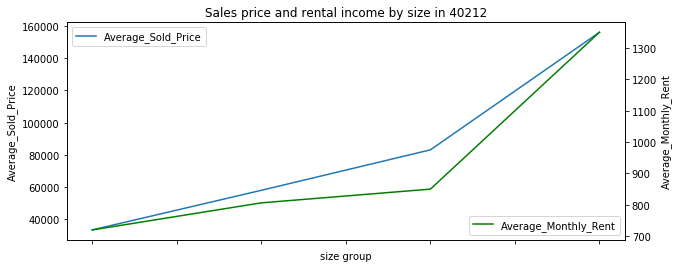

,size group,Average_Sold_Price,Average_Monthly_Rent
47,0 - 1000,"33,423",720
48,1000 - 2000,"58,014",806
49,2000 - 3000,"83,133",850
50,3000 - 4000,"156,159","1,350"


In [27]:
#create a line chart with a secondary y axis to display both the Sales and rental price by size group for the particular zip code

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# the ax keyword sets the axis that the data frame plots to
second_best_results_df.plot(ax=ax1, x='size group', y='Average_Sold_Price')
second_best_results_df.plot(ax=ax2, x='size group', y='Average_Monthly_Rent', color='g')
ax1.set_xlabel('size group')
ax1.set_ylabel('Average_Sold_Price')
ax2.set_ylabel('Average_Monthly_Rent')
ax1.legend(loc=0)
ax2.legend(loc='lower right')
fig.set_figwidth(10)
ax1.set_title(f'Sales price and rental income by size in {second_best_value}')

plt.show()
second_best_results_df

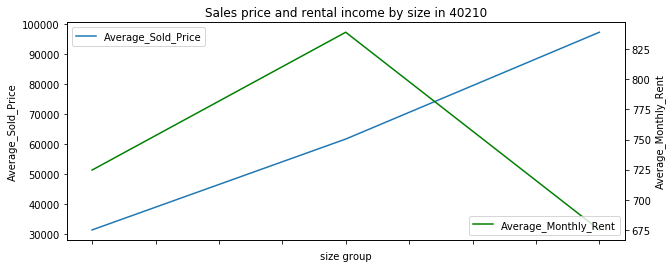

,size group,Average_Sold_Price,Average_Monthly_Rent
41,0 - 1000,"31,480",725
42,1000 - 2000,"61,790",839
43,2000 - 3000,"97,414",675


In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# the ax keyword sets the axis that the data frame plots to
third_best_results_df.plot(ax=ax1, x='size group', y='Average_Sold_Price')
third_best_results_df.plot(ax=ax2, x='size group', y='Average_Monthly_Rent', color='g')
ax1.set_xlabel('size group')
ax1.set_ylabel('Average_Sold_Price')
ax2.set_ylabel('Average_Monthly_Rent')
ax1.legend(loc=0)
ax2.legend(loc='lower right')
fig.set_figwidth(10)
ax1.set_title(f'Sales price and rental income by size in {third_best_value}')

plt.show()
third_best_results_df

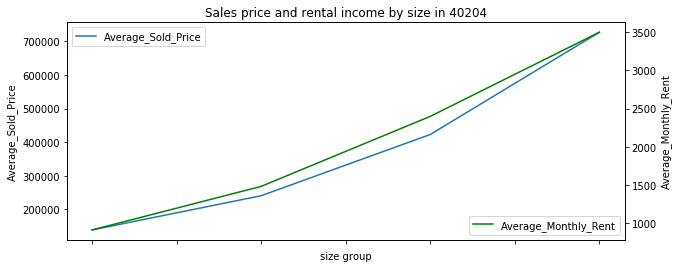

,size group,Average_Sold_Price,Average_Monthly_Rent
16,0 - 1000,"138,964",911
17,1000 - 2000,"240,669","1,482"
18,2000 - 3000,"422,797","2,398"
19,4000+,"726,875","3,500"


In [29]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# the ax keyword sets the axis that the data frame plots to
fourth_best_results_df.plot(ax=ax1, x='size group', y='Average_Sold_Price')
fourth_best_results_df.plot(ax=ax2, x='size group', y='Average_Monthly_Rent', color='g')
ax1.set_xlabel('size group')
ax1.set_ylabel('Average_Sold_Price')
ax2.set_ylabel('Average_Monthly_Rent')
ax1.legend(loc=0)
ax2.legend(loc='lower right')
fig.set_figwidth(10)
ax1.set_title(f'Sales price and rental income by size in {fourth_best_value}')

plt.show()
fourth_best_results_df

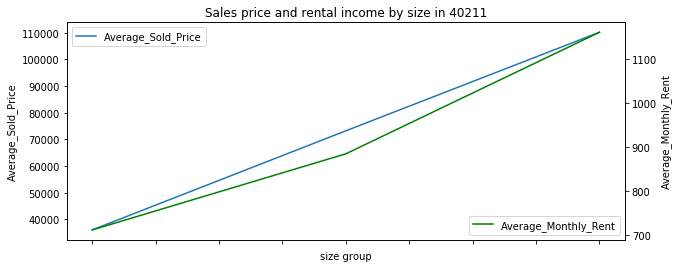

,size group,Average_Sold_Price,Average_Monthly_Rent
44,0 - 1000,"36,046",712
45,1000 - 2000,"73,241",885
46,2000 - 3000,"110,227","1,162"


In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# the ax keyword sets the axis that the data frame plots to
fifth_best_results_df.plot(ax=ax1, x='size group', y='Average_Sold_Price')
fifth_best_results_df.plot(ax=ax2, x='size group', y='Average_Monthly_Rent', color='g')
ax1.set_xlabel('size group')
ax1.set_ylabel('Average_Sold_Price')
ax2.set_ylabel('Average_Monthly_Rent')
ax1.legend(loc=0)
ax2.legend(loc='lower right')
fig.set_figwidth(10)
ax1.set_title(f'Sales price and rental income by size in {fifth_best_value}')

plt.show()
fifth_best_results_df